### Import Libraries

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import math
from wordcloud import WordCloud
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

## EDA

### Information

In [77]:
df = pd.read_csv('../data/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [79]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


### Distributions

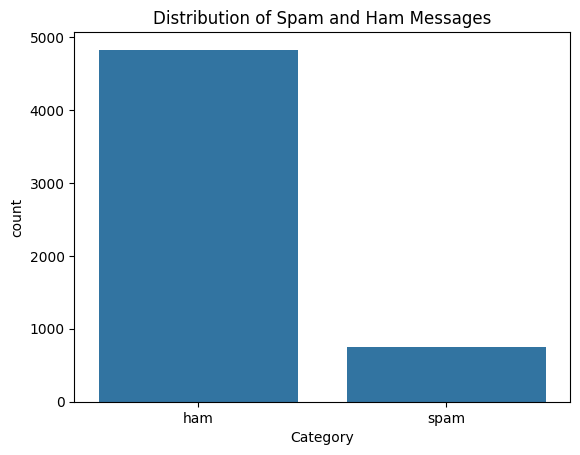

Percent of Category
ham     86.593683
spam    13.406317
Name: count, dtype: float64 


In [80]:
category_counts = df['Category'].value_counts()

sns.countplot(x='Category', data=df)
plt.title('Distribution of Spam and Ham Messages')
plt.show()

print(f"Percent of",category_counts / len(df) * 100, "")


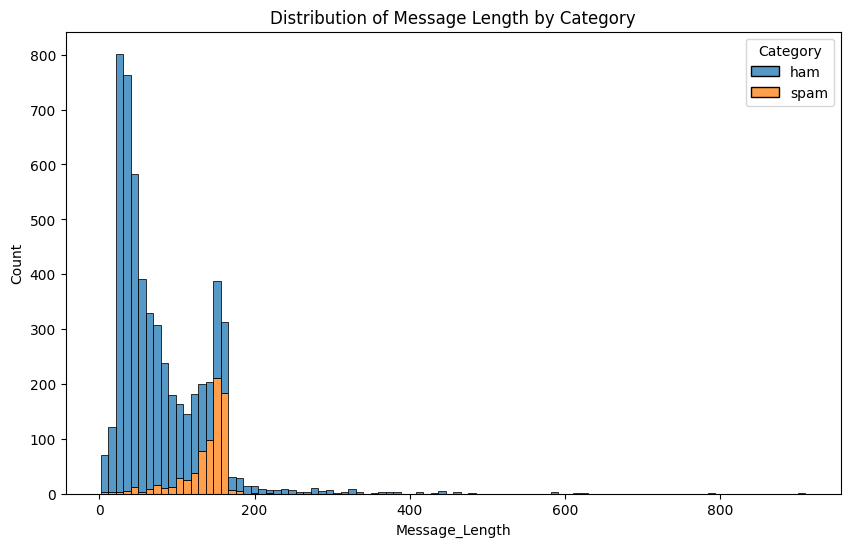

In [81]:
df['Message_Length'] = df['Message'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Message_Length', hue='Category', multiple='stack')
plt.title('Distribution of Message Length by Category')
plt.show()


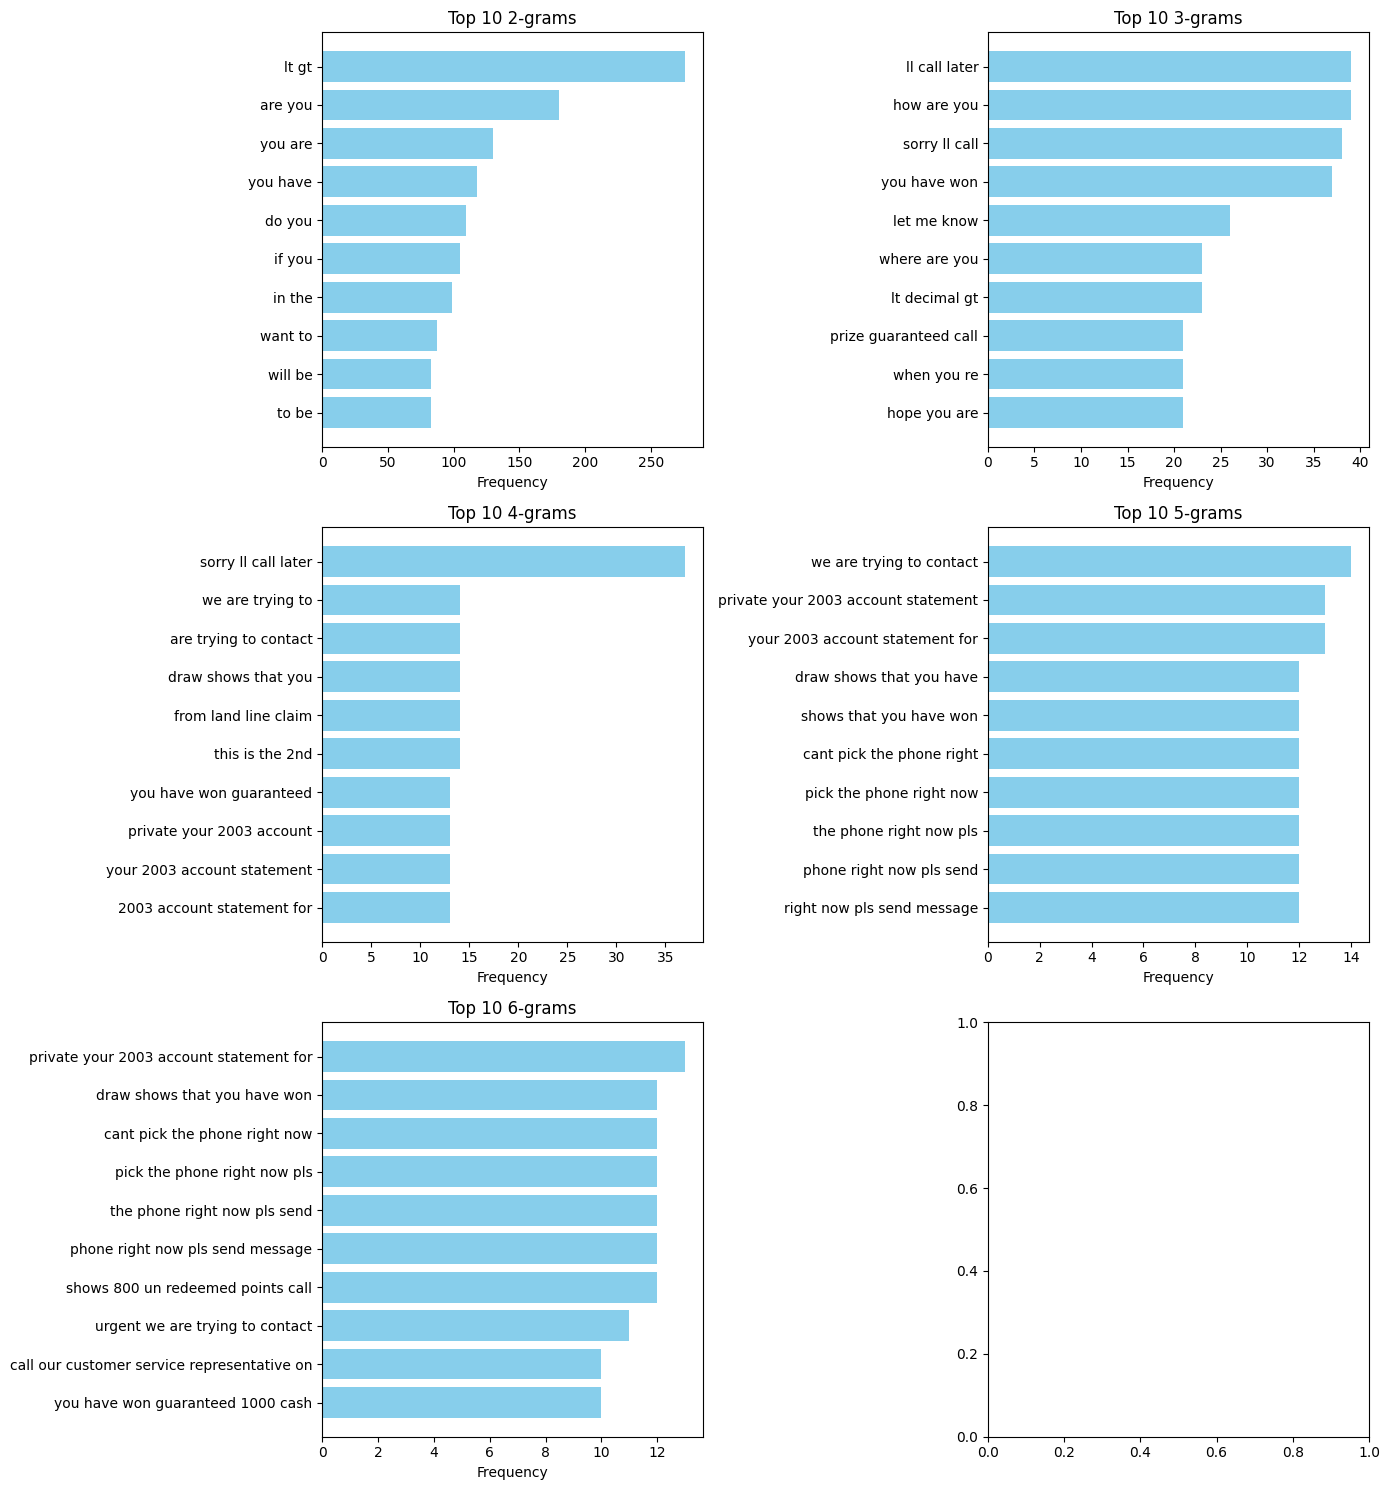

In [82]:
# Function to plot n-grams
def ngrams(corpus, max_n=6, top_n=10):
    rows = math.ceil(max_n / 2) 
    cols = 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 5))
    axes = axes.flatten()
    
    # Generate and plot n-grams for each n from 2 to max_n
    for i, n in enumerate(range(2, max_n + 1)):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        
        ngram_df = pd.DataFrame(words_freq[:top_n], columns=['Ngram', 'Frequency'])
        
        axes[i].barh(ngram_df['Ngram'], ngram_df['Frequency'], color='skyblue')
        axes[i].set_title(f'Top {top_n} {n}-grams')
        axes[i].set_xlabel('Frequency')
        axes[i].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
ngrams(df['Message'], max_n=6, top_n=10)


### Frecuencies

In [83]:
# Function to get top N most common words
def top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

spam_corpus = df[df['Category'] == 'spam']['Message']
spam_words = top_n_words(spam_corpus, n=20)
spam_df = pd.DataFrame(spam_words, columns=['Word', 'Frequency'])

ham_corpus = df[df['Category'] == 'ham']['Message']
ham_words = top_n_words(ham_corpus, n=20)
ham_df = pd.DataFrame(ham_words, columns=['Word', 'Frequency'])


In [84]:
ham_df.head(50)

,Word,Frequency
0,you,1948
1,to,1562
2,the,1133
3,and,858
4,in,823
5,me,777
6,my,754
7,is,739
8,it,718
9,that,560


In [85]:
spam_df.head(50)

,Word,Frequency
0,to,688
1,call,352
2,you,297
3,your,264
4,free,224
5,for,204
6,the,203
7,now,199
8,or,188
9,txt,163


In [86]:
# Correlation between message length and category
df['Category_Binary'] = df['Category'].map({'ham': 0, 'spam': 1})
correlation = df[['Message_Length', 'Category_Binary']].corr()
print(correlation)


                 Message_Length  Category_Binary
Message_Length         1.000000         0.378359
Category_Binary        0.378359         1.000000


### Filtering Spam Category

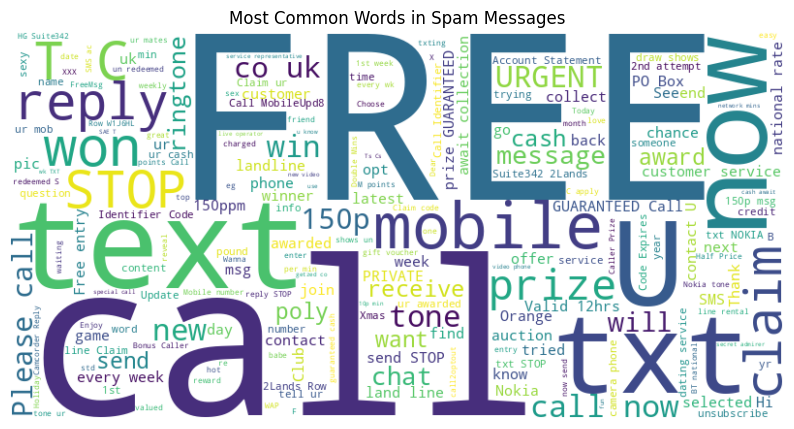

In [87]:
spam_messages = df[df['Category'] == 'spam']['Message']
spam_text = " ".join(spam_messages)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Spam Messages')
plt.show()


Log-Odds Ratio: Compare the frequency of words in spam versus ham to determine which words are more indicative of spam. Words with a high log-odds ratio are more characteristic of spam messages.

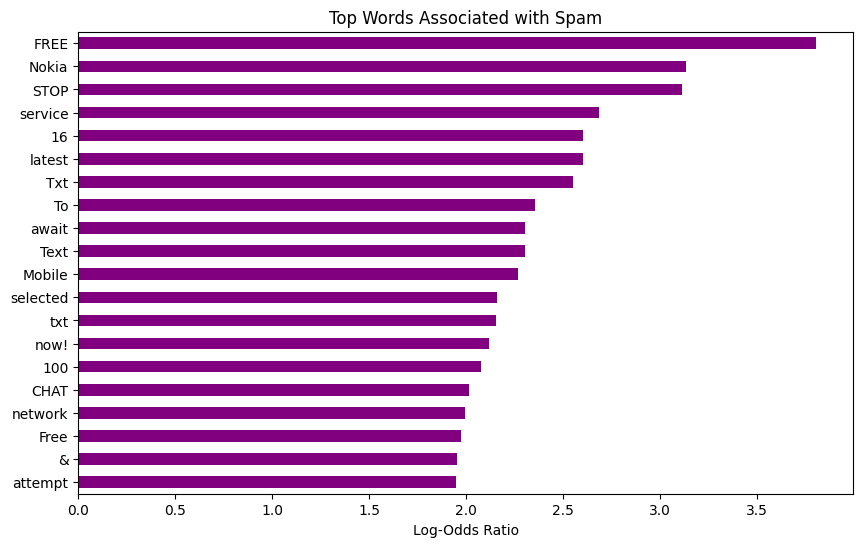

In [88]:
spam_freq = (df[df['Category'] == 'spam']['Message']
             .str.split(expand=True).stack().value_counts())
ham_freq = (df[df['Category'] == 'ham']['Message']
            .str.split(expand=True).stack().value_counts())

word_odds_ratio = np.log((spam_freq + 1) / (ham_freq + 1))
spammy_words = word_odds_ratio.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
spammy_words.plot(kind='barh', color='purple')
plt.xlabel('Log-Odds Ratio')
plt.title('Top Words Associated with Spam')
plt.gca().invert_yaxis()
plt.show()


TF-IDF Scores:

Term Frequency-Inverse Document Frequency (TF-IDF) is a technique that weights words not only by their frequency but also by how common the word is across all documents (in this case, messages). This helps identify words that are important in spam messages but not in the rest.

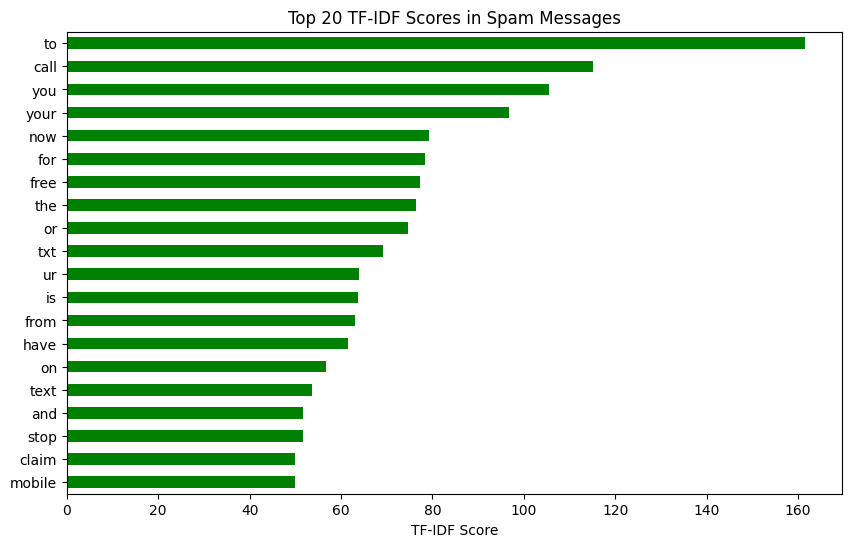

In [89]:
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(spam_messages)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_sum = tfidf_df.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
tfidf_sum.plot(kind='barh', color='green')
plt.xlabel('TF-IDF Score')
plt.title('Top 20 TF-IDF Scores in Spam Messages')
plt.gca().invert_yaxis()
plt.show()

Chi-Square Test: 
Help you identify which words are statistically more associated with the spam category.

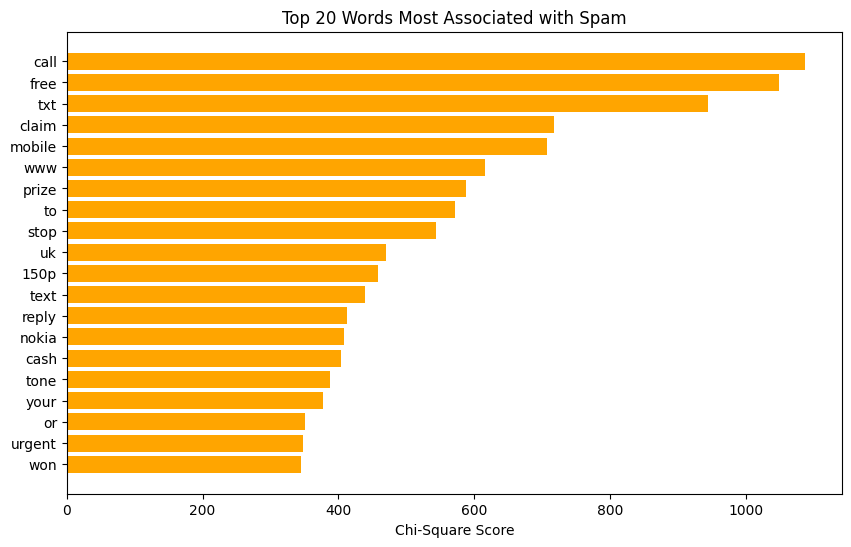

In [90]:
vec = CountVectorizer()
X = vec.fit_transform(df['Message'])
y = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

chi2_scores, p_values = chi2(X, y)

chi2_df = pd.DataFrame({'Word': vec.get_feature_names_out(), 'Chi2': chi2_scores, 'p_value': p_values})
chi2_df = chi2_df.sort_values(by='Chi2', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(chi2_df['Word'], chi2_df['Chi2'], color='orange')
plt.xlabel('Chi-Square Score')
plt.title('Top 20 Words Most Associated with Spam')
plt.gca().invert_yaxis()
plt.show()
